# Use pre-trained embeddings models

## Import modules

**Note**:This notebook requires at least 16gb of RAM and 2.2.4 version of keras.

In [1]:
# Check keras version
from keras import __version__ as version
assert version == "2.2.4"

Using TensorFlow backend.


In [2]:
from sklearn import __version__ as version
assert version=="0.19.1"

In [24]:
# Import modules for preprocessing
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

## Import data

In [4]:
# Import a subset of dataset
nrows = None # None

In [5]:
train_df = pd.read_csv("../input/../input/quora-insincere-questions-classification/train.csv", nrows=nrows)
test_df = pd.read_csv("../input/../input/quora-insincere-questions-classification/test.csv", nrows=nrows)
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


In [6]:
# Check train dataset
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [7]:
# Check test dataset
test_df.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


## Pre-processing steps

1. **Split the training dataset into train and val sample.**
   Cross validation is a time consuming process, so we conduct experiments using simple train-val split.

2. **Fill up the missing values** in the text column with '_na_'

3. **Tokenize** the text column and convert them to vector sequences

4. **Pad the sequence as needed**: if the number of words in the text is greater than 'max_len' trunacate them to 'max_len' or if the number of words in the text is lesser than 'max_len' add zeros for remaining values.

In [19]:
# Define configuration values 

embed_size = 100   # how big is each word vector
max_features = 850 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 90        # max number of words in a question to use

In [20]:
# 1. Split to train and val
train_df, val_df = train_test_split(train_df, test_size=0.08, random_state=2020)

In [21]:
# 2. Fill up the missing values
train_X = train_df["question_text"].fillna("_##_").values
val_X = val_df["question_text"].fillna("_##_").values
test_X = test_df["question_text"].fillna("_##_").values

In [22]:
# 3. Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))

train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

In [25]:
# 4. Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [26]:
# Get the target values
train_y = train_df['target'].values
val_y = val_df['target'].values

In [27]:
# Check values
train_X

array([[  0,   0,   0, ..., 495,  89,  48],
       [  0,   0,   0, ..., 248, 409,  43],
       [  0,   0,   0, ...,  29, 215,   7],
       ...,
       [  0,   0,   0, ..., 307, 821, 833],
       [  0,   0,   0, ...,   6, 197,  74],
       [  0,   0,   0, ...,  92, 237, 437]], dtype=int32)

In [28]:
## Check tokenizer properties
print(f"Number of words: {tokenizer.num_words}")
print(f"Number of documents: {tokenizer.document_count}")

print("")
print("Tokenizer Index")
[print(v) for i, v in enumerate(tokenizer.word_index.items()) if i < 5]
print("")
[print(v) for i, v in enumerate(tokenizer.index_word.items()) if i < 5]

print("")
print("Tokenizer word counts")
[print(v) for i, v in enumerate(tokenizer.word_counts.items()) if i < 5]

Number of words: 850
Number of documents: 1105501

Tokenizer Index
('the', 1)
('what', 2)
('is', 3)
('a', 4)
('to', 5)

(1, 'the')
(2, 'what')
(3, 'is')
(4, 'a')
(5, 'to')

Tokenizer word counts
('what', 386093)
('is', 375015)
('the', 563353)
('best', 52736)
('thing', 7187)


[None, None, None, None, None]

In [29]:
# Shuffling the data and print dimensions

np.random.seed(2021)
trn_idx = np.random.permutation(len(train_X))
val_idx = np.random.permutation(len(val_X))

train_X = train_X[trn_idx]
val_X = val_X[val_idx]

train_y = train_y[trn_idx]
val_y = val_y[val_idx]


print(f"train_X shape: {train_X.shape}")
print(f"train_y shape: {train_y.shape}")

print(f"val_X shape: {val_X.shape}")
print(f"val_y shape: {val_y.shape}")

train_X shape: (1105501, 90)
train_y shape: (1105501,)
val_X shape: (96131, 90)
val_y shape: (96131,)


## User pre-trained embeddings 

In [30]:
# Define Link for pre-trained embedding to use
EMBEDDING_FILE = '../input/nlpword2vecembeddingspretrained/glove.6B.300d.txt'

# Define function to read the pre-trained embeddings.
# Function returns the word along with the vector as tuple
# The .txt file with pre-trained embeddings, contains the word and the embedding vector separated by space, one word at the line.

def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

In [31]:
# Read the pre-trained embeddings
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

In [32]:
# Check embeddings
print(f"Number of words of pre-trained embeddings: {len(embeddings_index)}")

print("")
print(f"Number of dimensions of embeddings: {len(embeddings_index['the'])}")

print("")
[print(v) for i, v in enumerate(embeddings_index.items()) if i < 5]

Number of words of pre-trained embeddings: 400000

Number of dimensions of embeddings: 300

('the', array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.

[None, None, None, None, None]

In [33]:
# Get all embeddings into a numpy array
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

print(f"Numpy array with embeddings shape: {all_embs.shape}")

Numpy array with embeddings shape: (400000, 300)


In [34]:
# Prepare the word_index and the embedding_matrix
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

print(f"Embeddings matrix shape: {embedding_matrix.shape}")

Embeddings matrix shape: (850, 300)


In [35]:
# .items(): create a dir with tuples for iteration
# word_index.items()

In [36]:
# For every word, index get the embedded vector for the particular word
# and store it to the embedding_matrix

for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

        
print("Done creating embeddings matrix!")

Done creating embeddings matrix!


In [37]:
# number of rows: number of different questions in training set
# number of columns: number of features
print(f"Embeddings matrix shape: {embedding_matrix.shape}")

Embeddings matrix shape: (850, 300)


In [38]:
# 0-row is random 
# embedding_matrix[0,:]

## Feature Matrix

Now, we have our **word representation**, a vector for every word in our vocabulary. 
But we need to deal with full sentences so we need to create a **sentence embedding**, basically we need a vector that represent the whole sentence and every feature in the vector will be based on the word embeddings. 

There are many posibilities and we are notr going to cover this topic, so we apply a very simple method: 
* average: the ith value in the sentence embedding will be the mean of the ith values in the word embedding of all the words in the sentence.

In [39]:
embedding_matrix.shape

(850, 300)

In [40]:
train_X

array([[  0,   0,   0, ...,   6,  21, 112],
       [  0,   0,   0, ..., 169,  21, 111],
       [  0,   0,   0, ...,   6, 563,  57],
       ...,
       [  0,   0,   0, ..., 662,   7, 392],
       [  0,   0,   0, ..., 149,  18, 840],
       [  0,   0,   0, ...,  41, 305,   1]], dtype=int32)

In [41]:
# Importan Note:
# index=0 means that this word doesn't appear in this sentense
# index!=0 indicates a specific word from index

print(f"min word index: {train_X.min()}")
print(f"max word index: {train_X.max()}")

min word index: 0
max word index: 849


In [42]:
# // Development //

# words_indices = np.unique(train_X[0,:])
# words_indices = words_indices[words_indices!=0]
# words_indices = words_indices.tolist()
# words_indices

# print(f"Number of embedding vectors: {embedding_matrix[words_indices].shape} (the same as the number of the words in this sentence)")
# mean_vector = embedding_matrix[words_indices].mean(axis=0)
# mean_vector.shape

In [43]:
# Create Feature vectors for train_X

train_X_new = np.ndarray(shape = (len(train_X), 300))

for i in range(len(train_X)):
    
    words_indices = np.unique(train_X[i,:])
    words_indices = words_indices[words_indices!=0]
    words_indices = words_indices.tolist()
    
    # words_indices
    # print(f"Number of embedding vectors: {embedding_matrix[words_indices].shape} (the same as the number of the words in this sentence)")
    
    mean_vector = embedding_matrix[words_indices].mean(axis=0)
    
    # mean_vector.shape
    train_X_new[i,:] = mean_vector
    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [44]:
# Targets in training set (Imballanced dataset)
unique, counts = np.unique(train_y, return_counts=True)
dict(zip(unique, counts))

{0: 1037129, 1: 68372}

In [45]:
# Targets in training set (Imballanced dataset)
unique, counts = np.unique(val_y, return_counts=True)
dict(zip(unique, counts))

{0: 90261, 1: 5870}

In [46]:
# Create Feature vectors for val_X

val_X_new = np.ndarray(shape = (len(val_X), 300))

for i in range(len(val_X)):
    
    words_indices = np.unique(val_X[i,:])
    words_indices = words_indices[words_indices!=0]
    words_indices = words_indices.tolist()
    
    # words_indices
    # print(f"Number of embedding vectors: {embedding_matrix[words_indices].shape} (the same as the number of the words in this sentence)")
    
    mean_vector = embedding_matrix[words_indices].mean(axis=0)
    
    # mean_vector.shape
    val_X_new[i,:] = mean_vector

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  


## Training (Machine Learning models)

In [47]:
print(f"train_X_new shape: {train_X_new.shape}")
print(f"train_y shape: {train_y.shape}")

print(f"val_X_new shape: {val_X_new.shape}")
print(f"val_y shape: {val_y.shape}")

train_X_new shape: (1105501, 300)
train_y shape: (1105501,)
val_X_new shape: (96131, 300)
val_y shape: (96131,)


In [48]:
# Drop rows with NAs from train_X_new and train_y
mask = np.all(np.isnan(train_X_new), axis=1)
print(f"Number of rows to drop: {mask.sum()}")

print(train_X_new.shape)

train_X_new = train_X_new[~mask]
train_y = train_y[~mask]

Number of rows to drop: 162
(1105501, 300)


In [49]:
# Drop rows with NAs from val_X_new and val_y
mask = np.all(np.isnan(val_X_new), axis=1)
print(f"Number of rows to drop: {mask.sum()}")

print(val_X_new.shape)

val_X_new = val_X_new[~mask]
val_y = val_y[~mask]

Number of rows to drop: 15
(96131, 300)


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [51]:
# Train model
model = LogisticRegression(random_state=2021)
model.fit(train_X_new, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=2021, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Evaluate the model

In [90]:
# Make predictions
val_y_pred = model.predict(val_X_new)

print(classification_report(val_y, val_y_pred))
print(f1_score(val_y, val_y_pred))

             precision    recall  f1-score   support

          0       0.95      0.99      0.97     90250
          1       0.58      0.16      0.25      5866

avg / total       0.93      0.94      0.93     96116

0.2543567912731143


In [91]:
metrics.confusion_matrix(val_y, val_y_pred)

array([[89555,   695],
       [ 4910,   956]])

In [86]:
precision, recall, thresholds = precision_recall_curve(val_y,model.predict_proba(val_X_new)[:,1])
df = pd.DataFrame({"thresholds":np.append(0,thresholds), "precision":precision, "recall":recall})

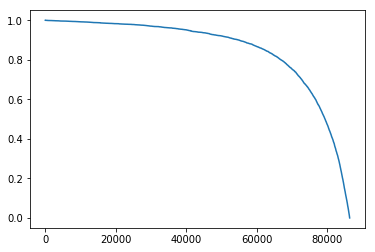

In [87]:
df["recall"].plot.line()

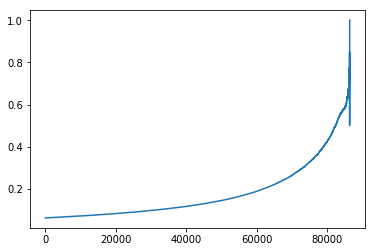

In [88]:
df["precision"].plot.line()

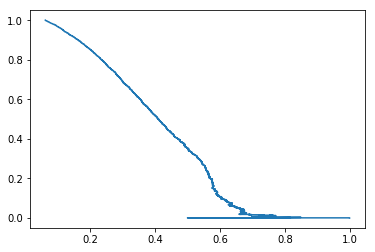

In [89]:
# Plot precision-recall curve
plt.plot(precision, recall);

## Training (Neural Network with keras)

In [3]:
# Import modules for training
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
# Define a neural network model
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])

In [ ]:
model.summary()
from tensorflow.keras.utils import plot_model 
plot_model(model, to_file='model1.png')